In [37]:
import pandas as pd
import sklearn.linear_model
import sklearn.svm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import urllib.request
import os
import json

from datetime import datetime
from html.parser import HTMLParser
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering

In [41]:
def plot_large():
    plt.figure(figsize=(8, 5), dpi=200)

sns.set()

In [3]:
lap_times = pd.read_csv('f1-data/lapTimes.csv')

In [4]:
driver_times = lap_times.groupby([lap_times.raceId, lap_times.driverId, lap_times.lap]).sum()

In [5]:
race_1_drivers = driver_times.loc[(1)].index.get_level_values(0).unique()

In [6]:
for driver in race_1_drivers:
    driver_times.loc[(1, driver)].milliseconds = np.cumsum(driver_times.loc[(1, driver)].milliseconds)

In [7]:
races = pd.read_csv('./f1-data/races.csv')
constructors = pd.read_csv('./f1-data/constructors.csv')
constructor_standings = pd.read_csv('./f1-data/constructorStandings.csv').drop(columns=['Unnamed: 7'])
results = pd.read_csv('f1-data/results.csv')
circuits = pd.read_csv('f1-data/circuits.csv', encoding='ISO-8859-1')

## Constructor classification
By checking the points tally for constructors at the end of a season, we can classify them into front runners, midfield, and backmarkers.

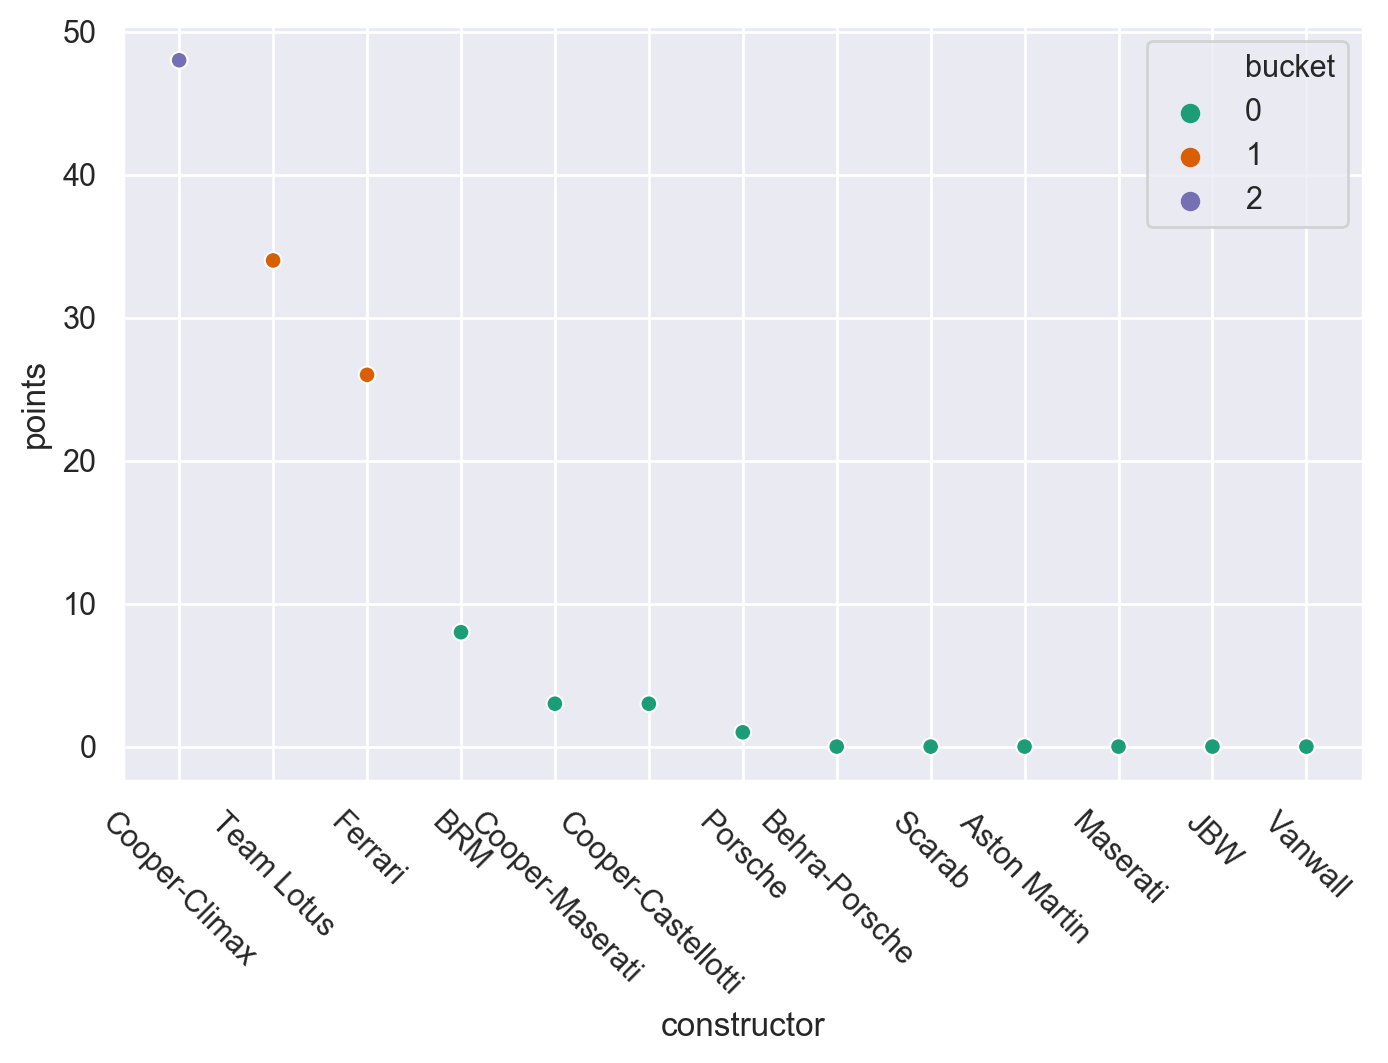

In [49]:
season = 1960

season_races = races[races['year'] == season]
features = constructor_standings[constructor_standings.raceId == season_races.raceId.max()]
features = features[['position', 'points', 'constructorId']]
features['constructor'] = [constructors[constructors.constructorId == x].name.values[0] for x in features['constructorId']]

num_buckets = 3

kmeans = KMeans(n_clusters=num_buckets)
kmeans.fit_predict(features[['position', 'points']])
features['bucket'] = kmeans.labels_
features = features.sort_values(by='position')

plot_large()
sns.scatterplot(x='constructor', y='points', hue='bucket', data=features,
                palette=sns.color_palette('Dark2', num_buckets))
plt.xticks(rotation=-45);

## F1 over the years
We can compare the lap times of Monaco over the years to see how F1 has gotten faster over the past few decades.

In [9]:
base_url = 'https://en.wikipedia.org/wiki/{}_Monaco_Grand_Prix'
pole_string = '<a href="/wiki/Pole_position" title="Pole position">Pole position</a>'
fastest_time_start = '<tr><th scope="row" style="width:20%;">Time</th><td colspan="3">'
fastest_time_end = '</td></tr>'
reference_str = '<sup id="cite_ref'
save_path = './f1-data/monacoTimes.csv'

monaco_df = pd.DataFrame(columns=['year', 'lapTimeMillis'])

def datetime_to_millis(dt):
    return (dt.minute * 60 * 1000) + (dt.second * 1000) + (dt.microsecond / 1000)

if os.path.exists(save_path):
    print("Using cached Monaco lap times!")
    monaco_df = pd.read_csv(save_path)
else:
    years = range(1955, 2018)
    parser = HTMLParser()
    print("Downloading data...")
    for year in years:
        print(year, end=", ")
        url = base_url.format(year)
        contents = str(urllib.request.urlopen(url).read())
        pole_index = contents.find(pole_string)
        start_index = contents.find(fastest_time_start, pole_index) + len(fastest_time_start) + 2
        end_index = contents.find(fastest_time_end, start_index)
        time = contents[start_index:end_index]

        if 'reference' in time:
            ref_index = contents.find(reference_str, start_index)
            time = contents[start_index:ref_index]

        if '(aggregate)' in time:
            ref_index = contents.find(' (aggregate)', start_index)
            time = contents[start_index:ref_index]

        try:
            timestamp = datetime.strptime(time, "%M:%S.%f")
        except:
            timestamp = datetime.strptime(time, "%M.%S.%f")
        monaco_df = monaco_df.append({'year': year, 'lapTimeMillis': datetime_to_millis(timestamp)}, ignore_index=True)

    print("DONE!")
    monaco_df.to_csv(save_path)

Using cached Monaco lap times!


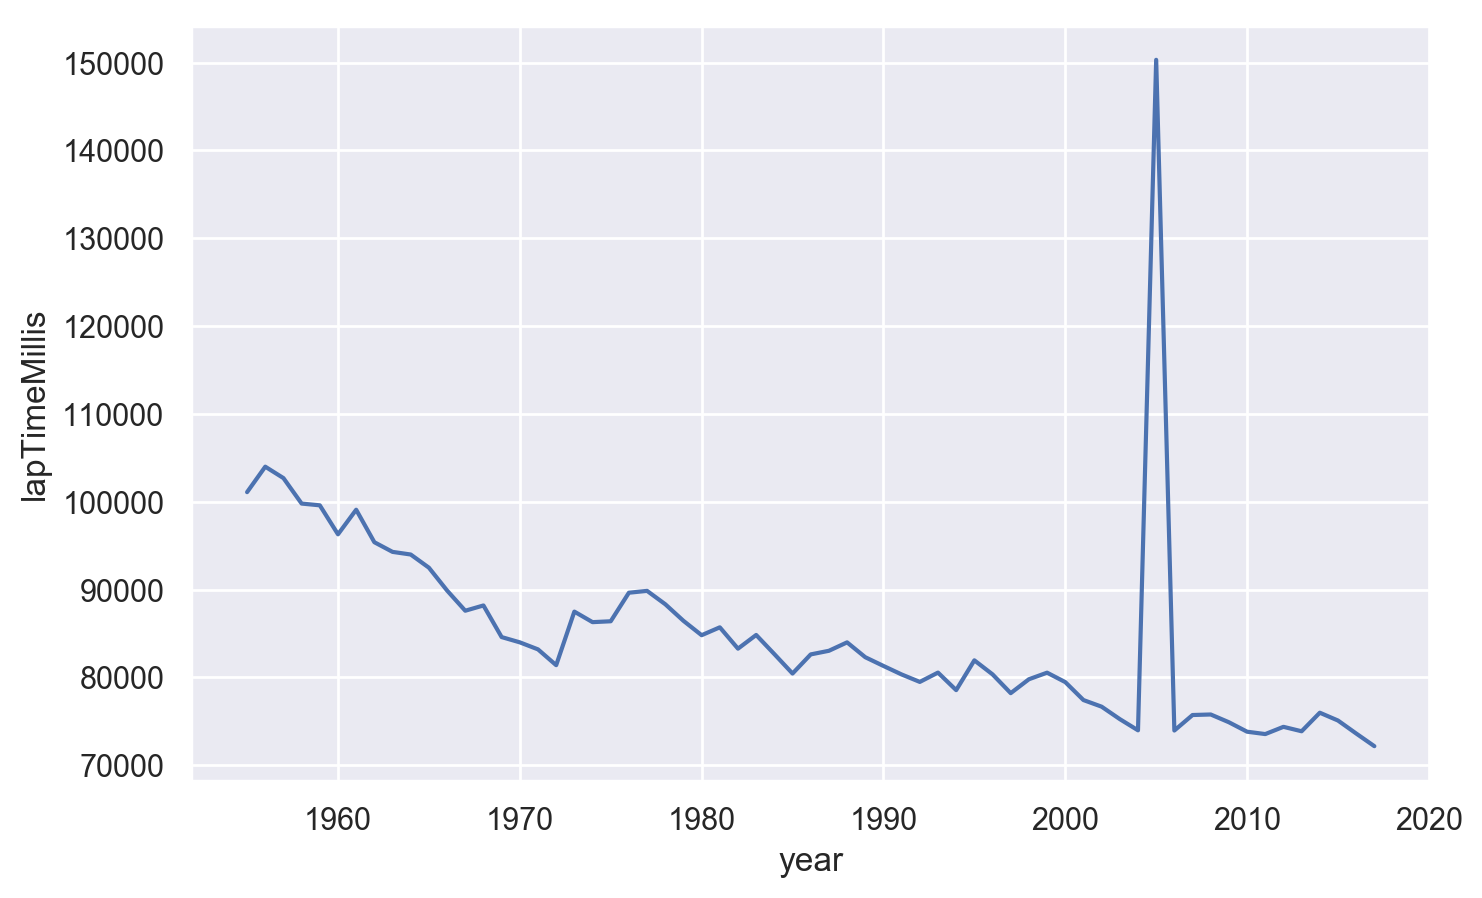

In [10]:
plot_large()
sns.lineplot(x='year', y='lapTimeMillis', data=monaco_df)

## Circuit difficulty
By getting the percentage of drivers who did not finish a race, we can estimate the difficulty of a circuit.

Using cached circuit data!


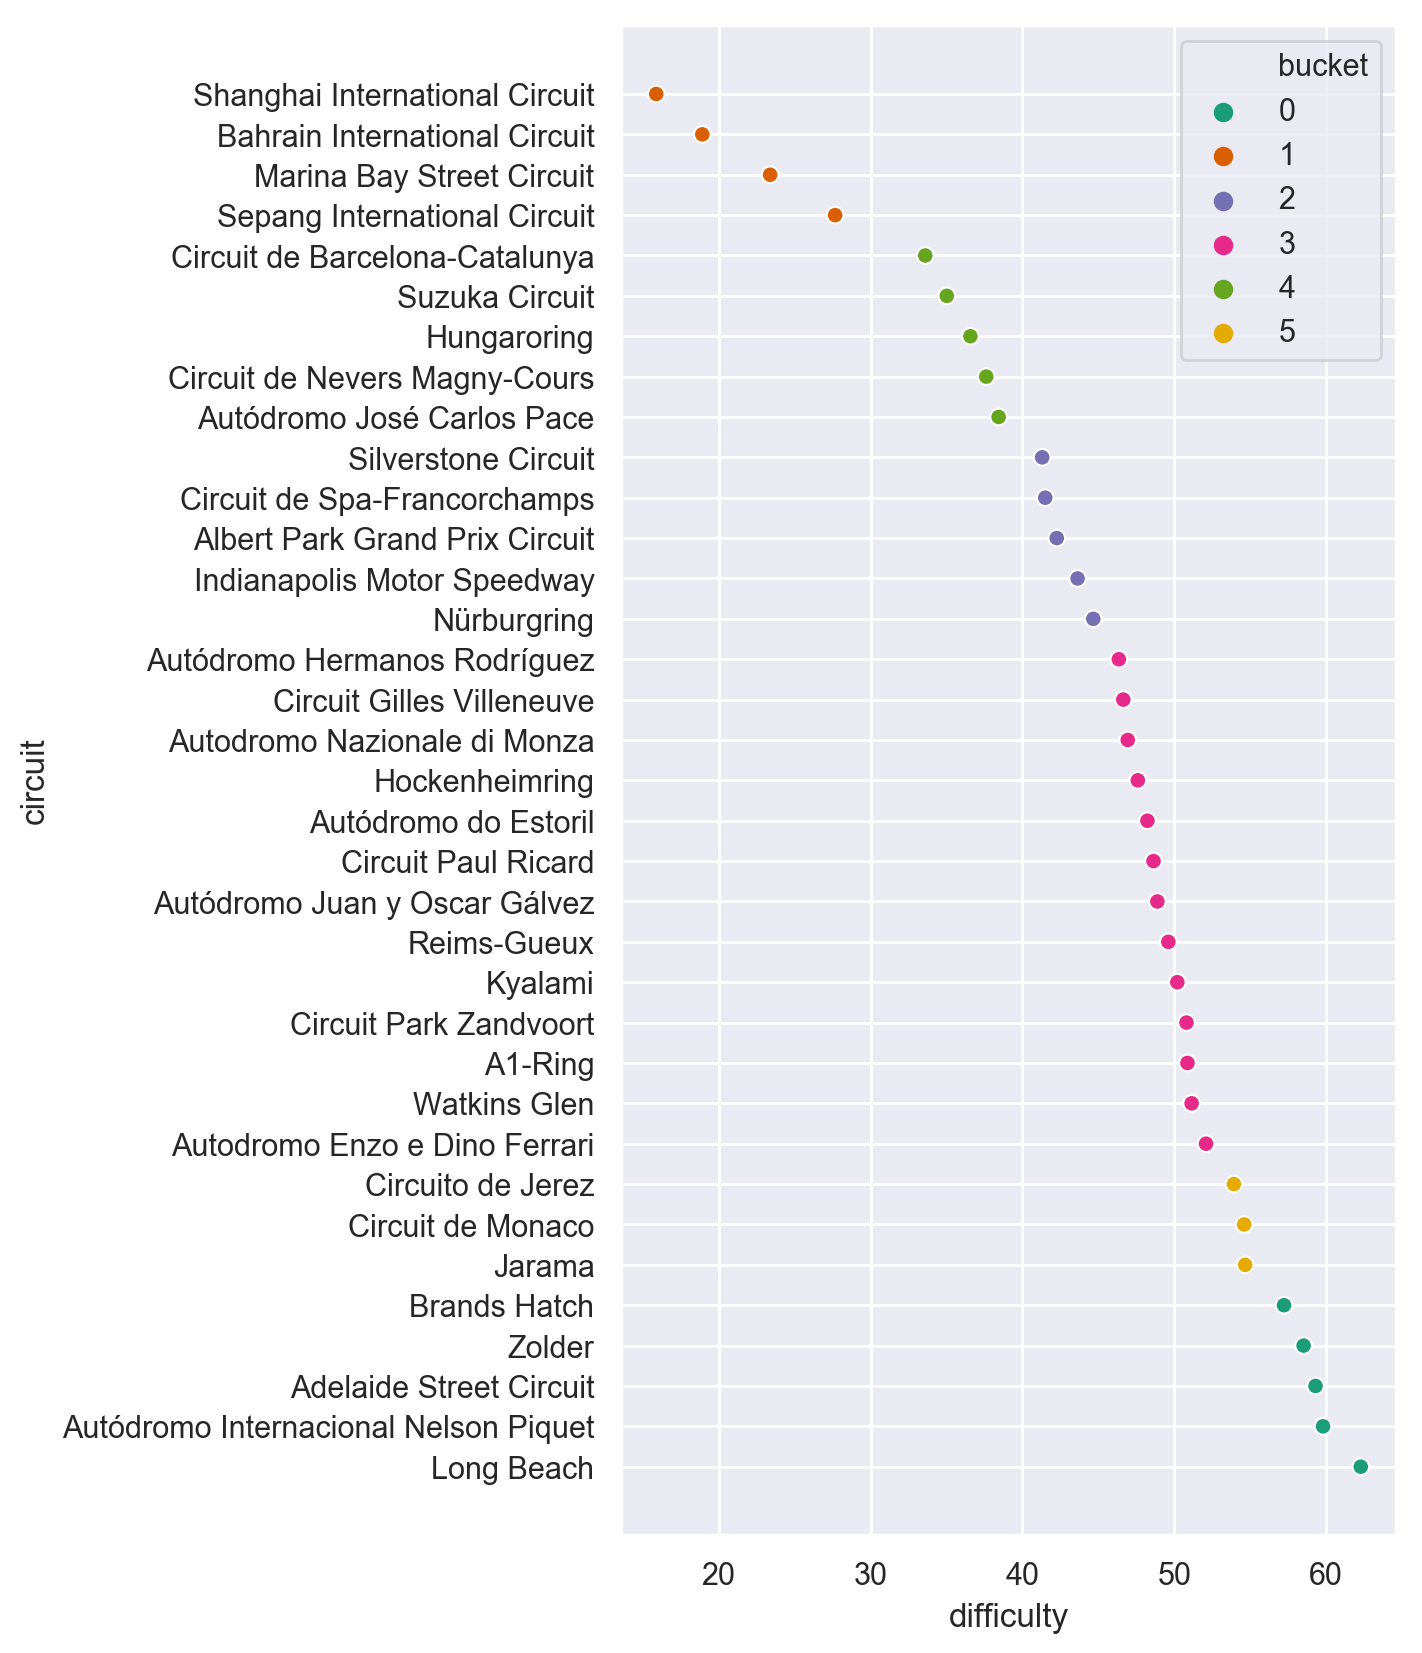

In [48]:
circuits_in_years = races.circuitId.unique()

save_path = './f1-data/circuitsGood.csv'

if os.path.exists(save_path):
    print("Using cached circuit data!")
    circuits_good = pd.read_csv(save_path)
else:
    print("Downloading data...")
    good_data = urllib.request.urlopen('http://ergast.com/api/f1/circuits.json?limit=100').read().decode('utf-8')
    better_data = json.loads(good_data)
    circuits_good = pd.DataFrame(better_data['MRData']['CircuitTable']['Circuits'])
    circuits_good.to_csv(save_path)

circuit_data = {'circuit': [], 'difficulty': []}
for circuitId in circuits_in_years:
    circuit_races = races[races.circuitId == circuitId]
    num_invalid = len(results[(results.raceId.isin(circuit_races.raceId)) & (results.position.isna())])
    total = len(results[(results.raceId.isin(circuit_races.raceId))])
    circuit_ref = circuits[circuits.circuitId == circuitId].circuitRef.values[0]
    circuit_name = circuits_good[circuits_good.circuitId == circuit_ref].circuitName.values[0]
    percent_invalid = num_invalid * 100 / total
    if total > 200:
        circuit_data['circuit'].append(circuit_name)
        circuit_data['difficulty'].append(percent_invalid)

circuit_difficulty_df = pd.DataFrame.from_dict(circuit_data).sort_values(by='difficulty', ascending=False)

num_buckets = 6

clustering_model = sklearn.cluster.SpectralClustering(n_clusters=num_buckets)
clustering_model.fit_predict(circuit_difficulty_df['difficulty'].values.reshape(-1, 1))
circuit_difficulty_df['bucket'] = clustering_model.labels_.astype(str)

plt.figure(figsize=(5, 10), dpi=200)
sns.scatterplot(y='circuit', x='difficulty', hue='bucket', data=circuit_difficulty_df,
                palette=sns.color_palette('Dark2', num_buckets));